In [ ]:
import google.colab
from pathlib import Path

google.colab.drive.mount("/content/drive", force_remount=True)

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/EyesDataset.zip', 'r') as archive:
    archive.extractall()

Mounted at /content/drive


In [ ]:
import sys

import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")

physical_device = tf.config.experimental.list_physical_devices('GPU')
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.11.0
GPU is NOT AVAILABLE


##  Loading the data

In [ ]:
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import pathlib
import sys

import tensorflow as tf
DB_PATH = "/home/komleva/yolov5_new/dataset/train"
BUFFER_SIZE = 10000
BATCH_SIZE = 1000
IMG_WIDTH = 60
IMG_HEIGHT = 60

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image,channels=3)

    input_image = tf.cast(image, tf.float32)
    return input_image

def random_crop(input_image):
    cropped_image = tf.image.random_crop(
      input_image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image

def resize(input_image):
    input_image = tf.image.resize(input_image, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image

def normalize(input_image):
    input_image = (input_image / 255)
    return input_image

@tf.function()
def random_jitter(input_image):
    input_image = random_crop(input_image)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        
    return input_image

def load_image_train(image_file):
    input_image = load(image_file)
    #input_image = random_jitter(input_image)
    input_image = resize(input_image)
    input_image = normalize(input_image)

    return input_image,input_image

def load_image_test(image_file):
    input_image = load(image_file)
    #input_image = random_jitter(input_image)
    input_image = resize(input_image)
    input_image = normalize(input_image)

    return input_image,input_image


data_dir = pathlib.Path(DB_PATH)
image_count = len(list(data_dir.glob('*.jpg')))
dataset = tf.data.Dataset.list_files('/content/EyesDataset/' + r'*.jpg')


val_size = 2000#int(image_count * 0.2)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)
print(val_size)
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


train_ds = train_ds.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_ds = val_ds.map(load_image_test)
val_ds = val_ds.batch(BATCH_SIZE)


2000
2000
2000


## Dataset visualization

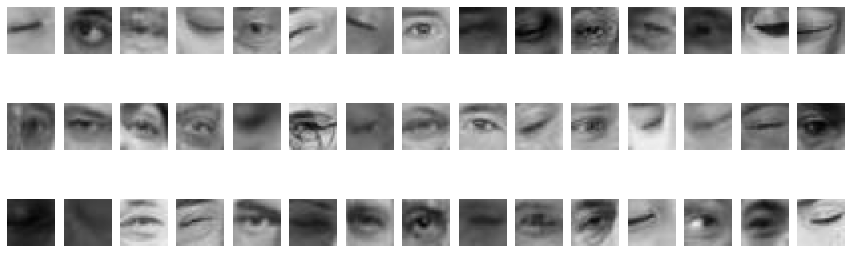

In [ ]:
#image_batch = next(iter(train_ds))

plt.figure(figsize=(15, 5))
for images,targets in val_ds.take(1):
    for i in range(45):
      ax = plt.subplot(3, 15, i + 1)
      plt.imshow(images[i].numpy().astype("float32"))
      plt.axis("off")

## Embedding of Data into PCA Space

In [ ]:
# Embedding Images to PCA Space
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(16)
imgs_list = []
vis_imgs = []
for images,targets in val_ds.take(1):
    for i in range(BATCH_SIZE):
        vis_imgs.append(tf.keras.preprocessing.image.img_to_array(images[i]))
        image = tf.image.rgb_to_grayscale(images[i])
        img_arr = tf.keras.preprocessing.image.img_to_array(image)
        imgs_list.append(img_arr.ravel())
img_mat = np.array(imgs_list)
print("Image Mat Shape:")
print(img_mat.shape)
pca_feat = pca.fit_transform(img_mat)
print("No. of PCA Features:")
print(pca_feat.shape)

Image Mat Shape:
(1000, 3600)
No. of PCA Features:
(1000, 16)


In [ ]:
pca_feat

array([[ 1.0899237e+01,  1.3136660e+00, -5.5300528e-01, ...,
         5.9425461e-01, -1.6421703e-01,  1.9176686e-01],
       [ 8.7743244e+00,  2.2977946e+00,  5.8109099e-01, ...,
        -8.8934314e-01, -6.9283712e-01,  1.1072168e+00],
       [ 2.6238914e+00,  1.2215948e+00, -1.2943590e+00, ...,
         4.1165398e-04, -4.8061737e-01, -5.2275240e-01],
       ...,
       [-2.2163296e+01, -5.0369272e+00,  2.3186505e+00, ...,
        -1.9686037e-01,  1.5286362e+00, -1.3975452e+00],
       [-3.6504142e-02,  3.5862751e+00, -2.9460256e+00, ...,
         1.4885606e+00,  7.8538984e-01,  1.1547323e-01],
       [ 5.2056293e+00,  4.2175450e+00, -2.7342854e+00, ...,
        -1.2941284e-01, -6.2130761e-01,  3.1689590e-01]], dtype=float32)

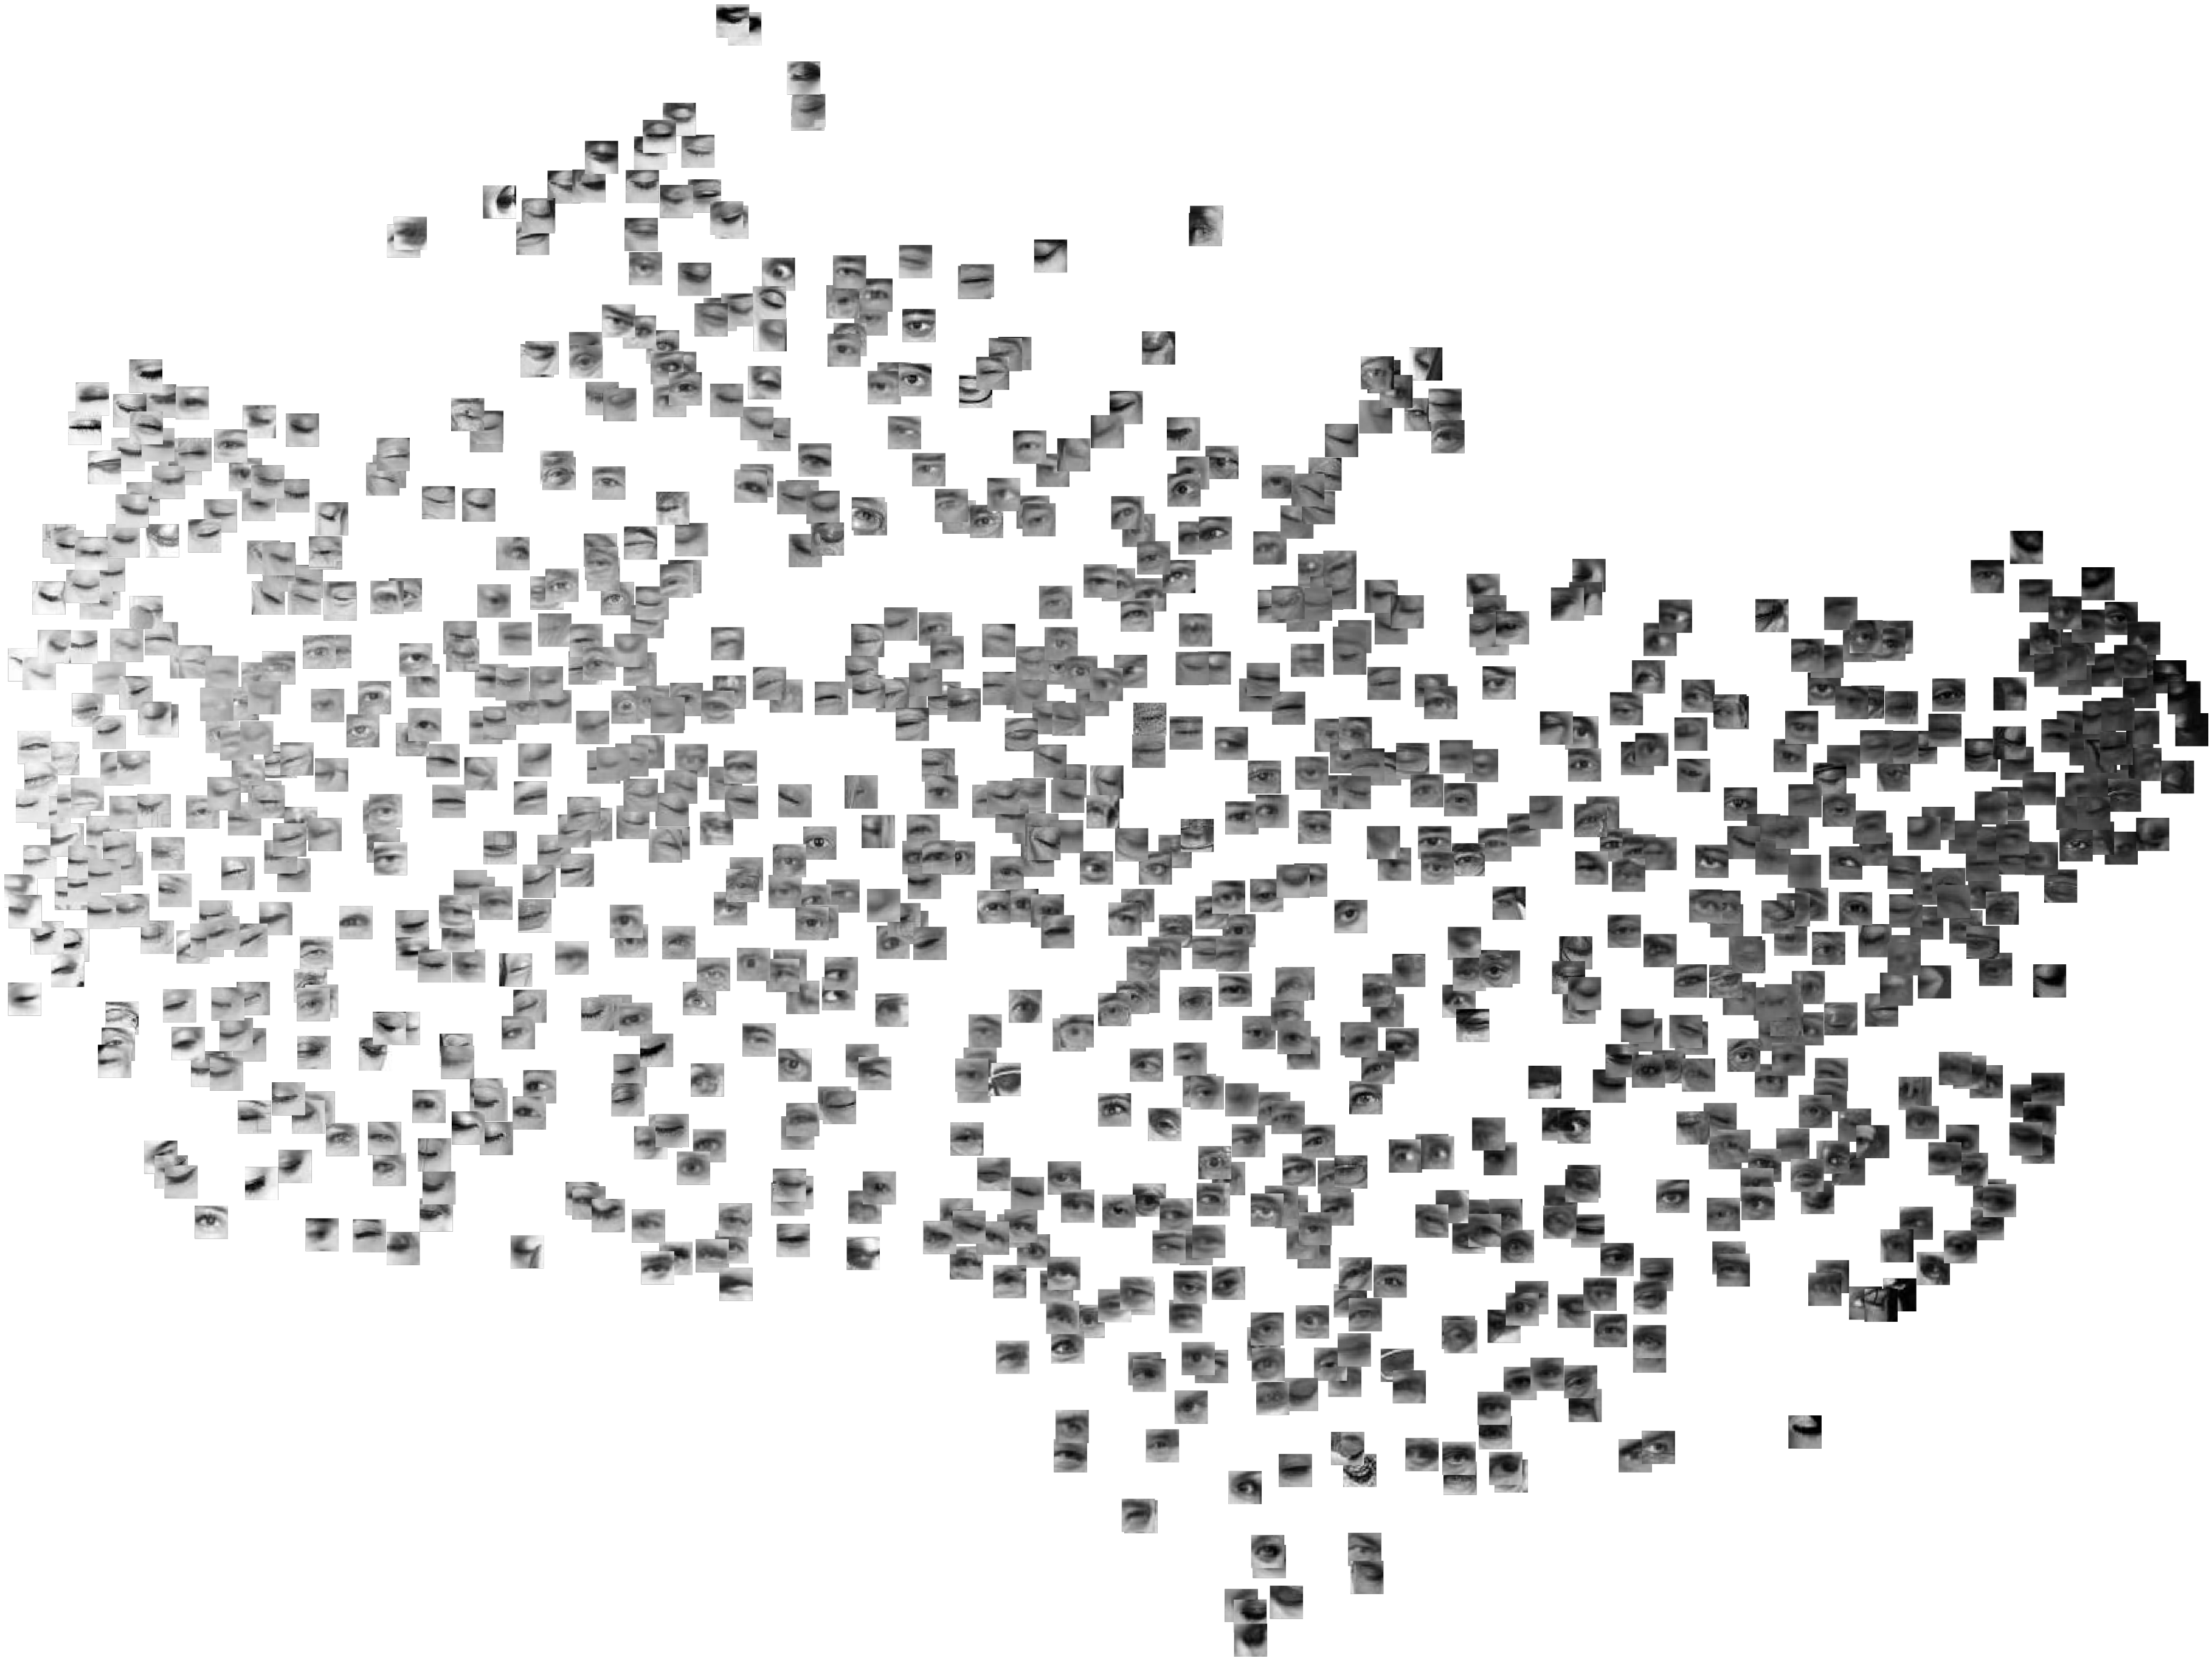

In [ ]:
from PIL import Image
from sklearn.manifold import TSNE

def visualize_space(X,images,outfile):

    tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
    tx, ty = tsne[:,0], tsne[:,1]
    tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
    width = 4000
    height = 3000


    full_image = Image.new('RGBA', (width, height))
    for img, x, y in zip(images, tx, ty):
        img = np.array(img)
        tile = Image.fromarray(np.uint8(img*255))
        full_image.paste(tile, (int((width-60)*x), int((height-60)*y)), mask=tile.convert('RGBA'))

    plt.figure(figsize = (66,50))
    plt.imshow(full_image)
    plt.axis("off")
    full_image.save(outfile)

X = np.array(pca_feat)
visualize_space(X,vis_imgs,"tSNE-PCA-eye.png")

## Building Encoder

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

import tensorflow.keras.backend as K

batch_size = 16
latent_dim = 32  # Number of latent dimension parameters

input_img = Input(shape=(60, 60, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = MaxPool2D( (2, 2), padding='same')(x)

x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)

shape_before_flattening = K.int_shape(x)
print(shape_before_flattening)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)

Z = Dense(latent_dim)(x)
print(K.int_shape(Z))

encoder = Model(input_img,Z)
encoder.summary()

(None, 8, 8, 1)
(None, 32)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 60, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None

## Building Decoder

In [ ]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(Z)[1:])
x = Dense(15*15*4, activation='relu', name="intermediate_decoder", input_shape=(latent_dim,))(decoder_input)

x = Dense(900, activation='sigmoid', name="original_decoder")(x)
x = Reshape((15,15,4),input_shape=(900,))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)

x = Conv2DTranspose(3, (3, 3), padding='same')(x)
x = UpSampling2D( (2, 2))(x)


# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(Z)

decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 intermediate_decoder (Dense  (None, 900)              29700     
 )                                                               
                                                                 
 original_decoder (Dense)    (None, 900)               810900    
                                                                 
 reshape (Reshape)           (None, 15, 15, 4)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 15, 15, 3)        111       
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 30, 30, 3)        0   

## Training Model

In [ ]:
# VAE model statement
ae = Model(input_img,z_decoded)
ae.compile(optimizer='adam', loss='mse')

ae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 60, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 4)         580 

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=5, mode='auto')
history = ae.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[early_stopping],verbose=1)

Epoch 1/100
2/2 [==============================] - 13s 7s/step - loss: 0.0362 - val_loss: 0.0358
Epoch 2/100
2/2 [==============================] - 9s 5s/step - loss: 0.0349 - val_loss: 0.0340
Epoch 3/100
2/2 [==============================] - 9s 6s/step - loss: 0.0337 - val_loss: 0.0329
Epoch 4/100
2/2 [==============================] - 10s 6s/step - loss: 0.0324 - val_loss: 0.0306
Epoch 5/100
2/2 [==============================] - 9s 5s/step - loss: 0.0304 - val_loss: 0.0293
Epoch 6/100
2/2 [==============================] - 9s 5s/step - loss: 0.0291 - val_loss: 0.0290
Epoch 7/100
2/2 [==============================] - 10s 5s/step - loss: 0.0303 - val_loss: 0.0276
Epoch 8/100
2/2 [==============================] - 11s 7s/step - loss: 0.0286 - val_loss: 0.0283
Epoch 9/100
2/2 [==============================] - 8s 5s/step - loss: 0.0289 - val_loss: 0.0267
Epoch 10/100
2/2 [==============================] - 10s 5s/step - loss: 0.0278 - val_loss: 0.0256
Epoch 11/100
2/2 [================

## Visualizating the Latent Space

In [ ]:
# Project validation set into Latent Space
vis_imgs = []
for input_images,output_images in val_ds.take(1):
    latent_vec = encoder(input_images)
    for i in range(BATCH_SIZE):
        vis_imgs.append(tf.keras.preprocessing.image.img_to_array(input_images[i]))
print("Dimension of Latent Space:")
print(latent_vec.shape)

Dimension of Latent Space:
(1000, 32)


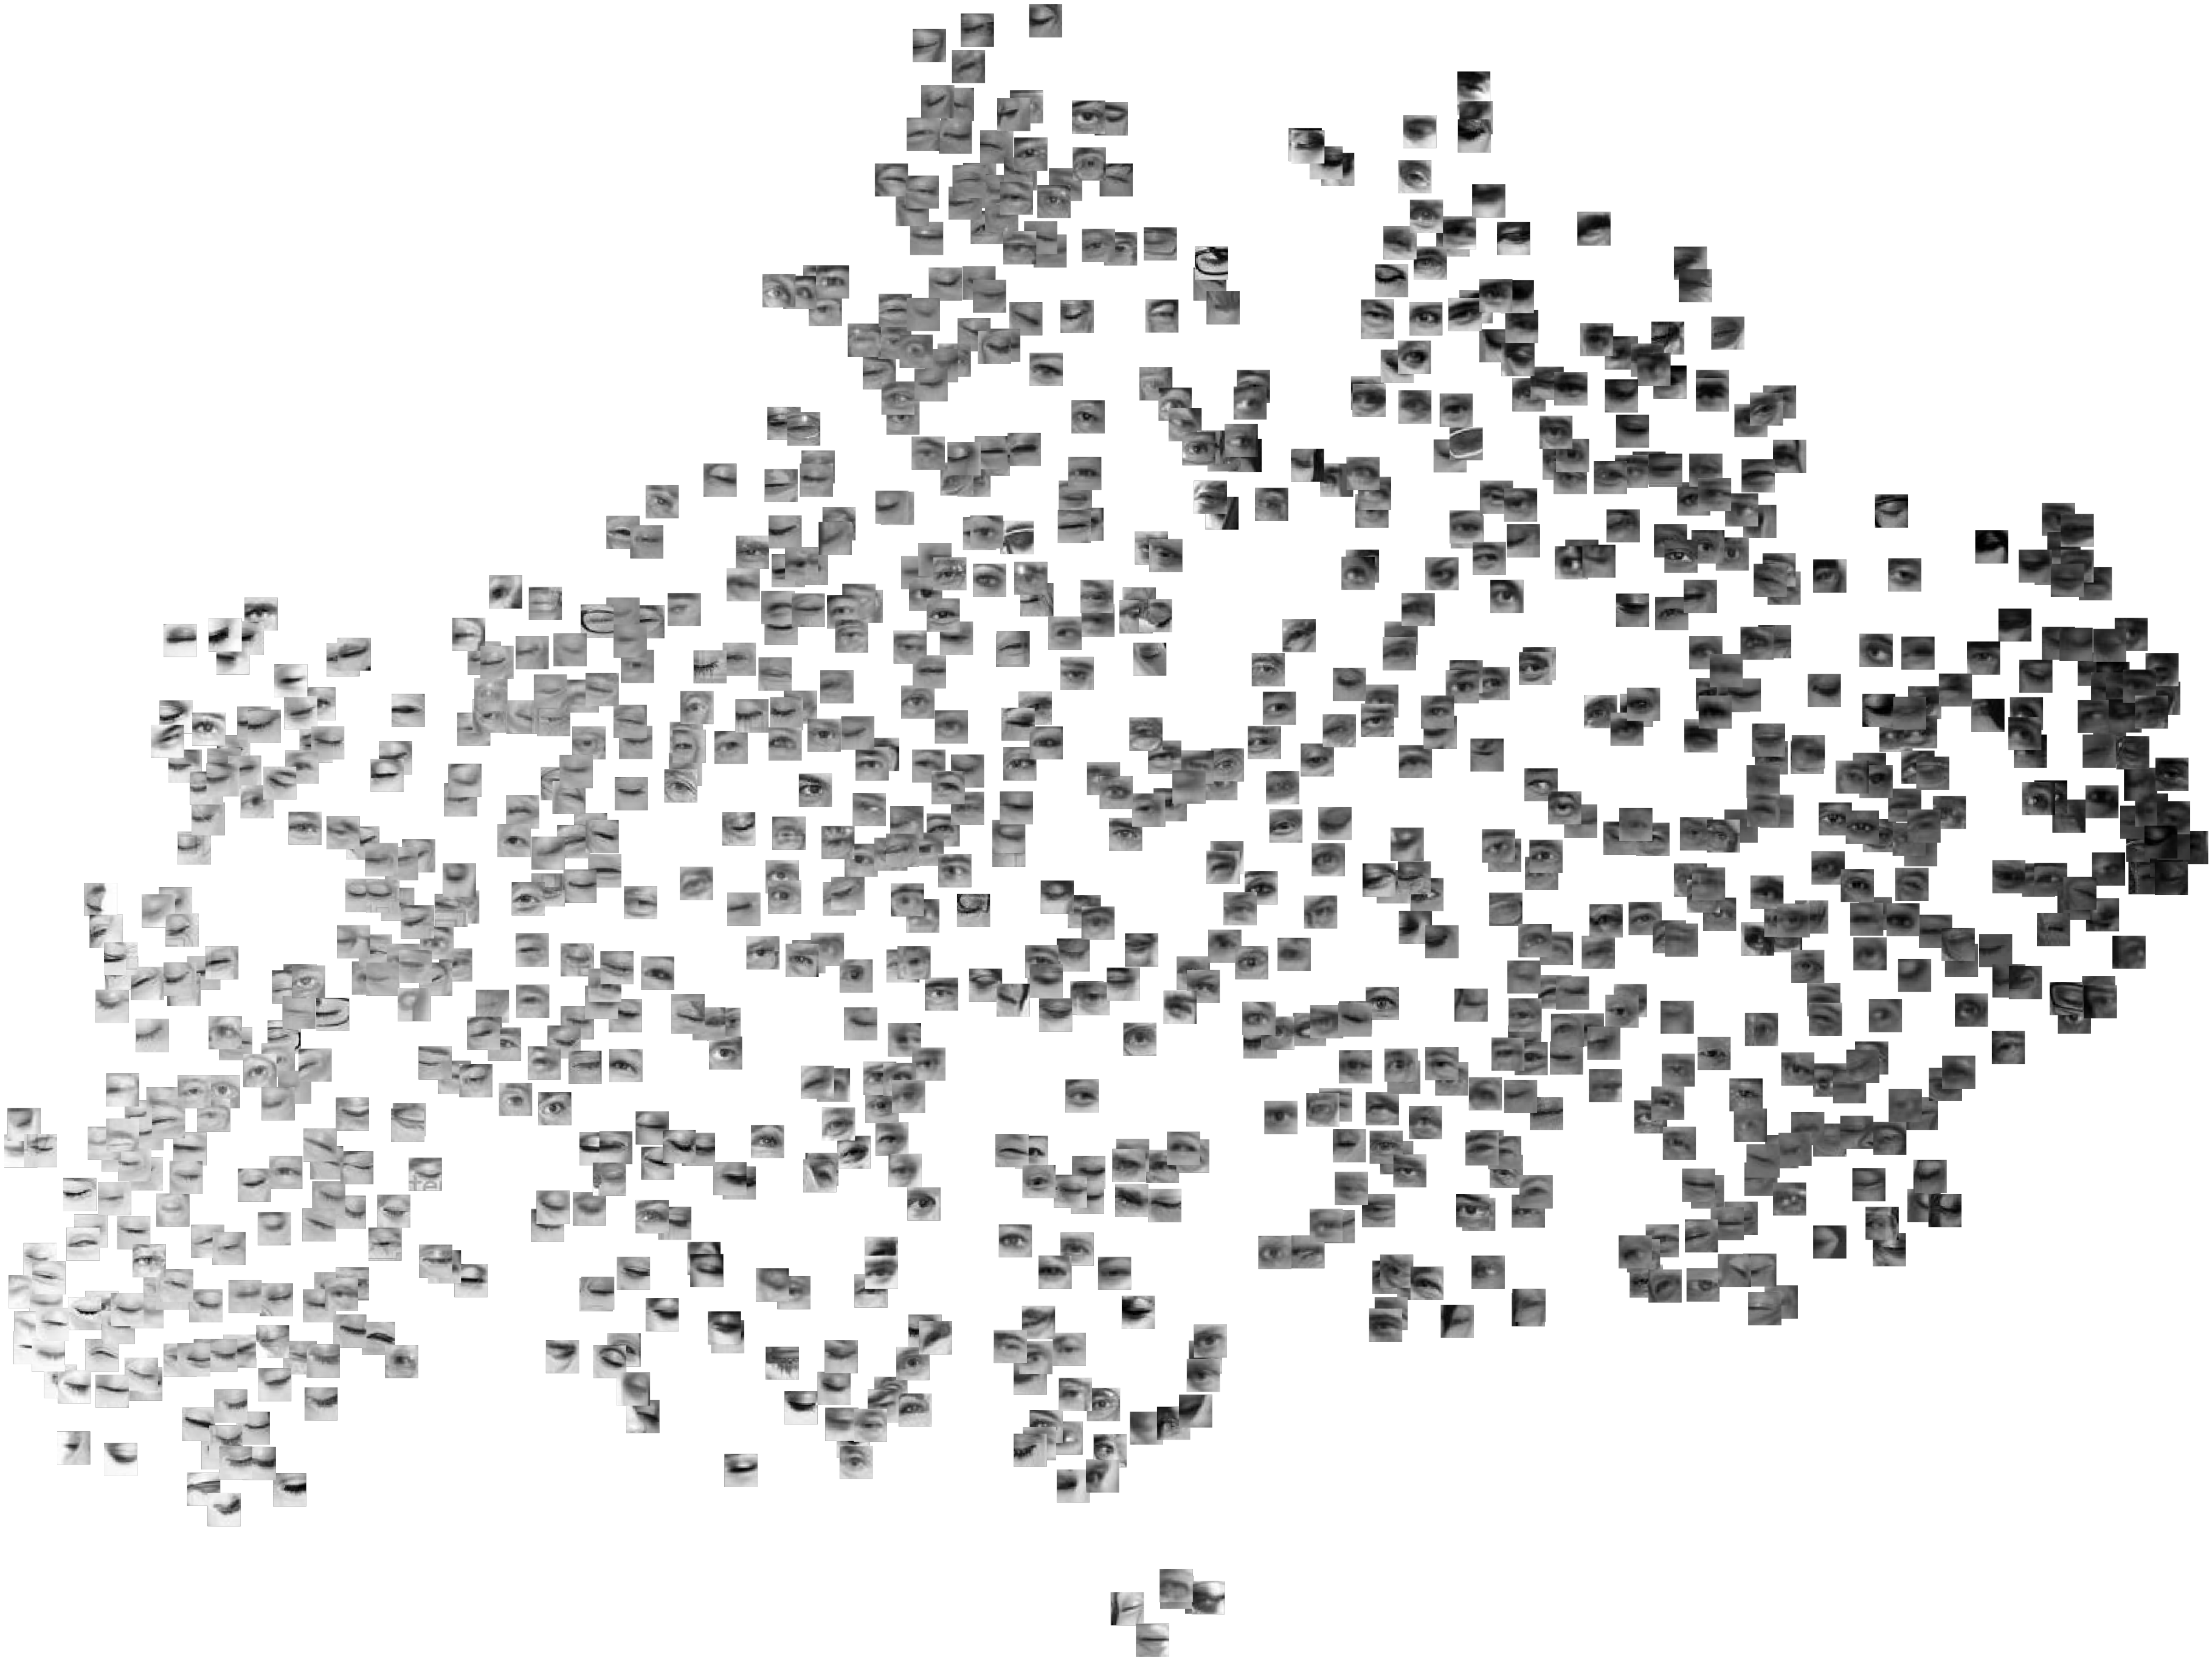

In [ ]:
X= np.array(latent_vec)

visualize_space(X,vis_imgs,"tSNE-Latent-eye.png")